In this example we reduce the data for a delay scan using the time tool, stack two runs, load the stacked data, separate the isotropic and anisotropic components, and plot them. 

# inputs

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import h5py
import sys
import os
import time
import scipy
import scipy.io as scio
from scipy.optimize import curve_fit


from LCLSDataToolsNew.GeneralTools import *
from LCLSDataToolsNew.filterTools import *
from LCLSDataToolsNew.diffSignalTools import *
from LCLSDataToolsNew.binningToolsErr import *
from LCLSDataToolsNew.anisotropyToolsAll import *
from LCLSDataToolsNew.SVDTools import *
from LCLSDataToolsNew.SetUpFns import *
from LCLSDataToolsNew.DiffBinFns import *
from LCLSDataToolsNew.ReduceFns import *
from LCLSDataToolsNew.IRFtools import *
from LCLSDataToolsNew.plottingTools import *

print('Import Complete!')

exper = 'xcslv9618'
### ffb ###
# smalldata_folder='/cds/data/drpsrcf/xcs/'+exper+'/scratch/hdf5/smalldata/'
### call ffb from psana ###
# smalldata_folder='/reg/data/drpsrcf/xcs/'+exper+'/scratch/hdf5/smalldata/'
### psana ###
smalldata_folder='/reg/d/psdm/xcs/'+exper+'/hdf5/smalldata/'


# outpath='/reg/d/psdm/xcs/'+exper+'/results/ReducedData/'
# outpath='/reg/d/psdm/xcs/'+exper+'/scratch/slr/'
outpath='/cds/home/s/slraj/code/ScatteringCode/'


Import Complete!


## set up varDict

In [2]:
varDict = {
        'ipm4'          : 'ipm4/sum',
        'ipm5'          : 'ipm5/sum',
        'xray_status'   : 'lightStatus/xray',
        'laser_status'  : 'lightStatus/laser',
        'ebeam_hv'      : 'ebeam/photon_energy',
        'scan_vec'      : 'scan/var0',
        'laser_diode'   : '/diodeGon/channels/',
    
        ## tt variables
        'ttCorr'        : 'tt/ttCorr',
        'ttAMPL'        : 'tt/AMPL',
        'ttFWHM'        : 'tt/FLTPOSFWHM',
        'ttFLTPOS'      : 'tt/FLTPOS',
        'encoder'       : 'enc/lasDelay',
        'lxt'           : 'epics/lxt' , 

        
        ## scattering variables
        'azav'      : 'epix10k2M/azav_azav',
        'qs'        : 'UserDataCfg/epix10k2M/azav__azav_q',
        'phis'      :  'UserDataCfg/epix10k2M/azav__azav_phiVec',


        }

## set up paramDict

In [3]:
setbins=np.arange(-1e-12,5.5e-12,.2e-12)


paramDict= {
        'binSetup'  : 'fixed',
        'binSet2'   : setbins,
        'binMethod' : 'ave', 
        'qnorm'     : (5,6), 
        'qrange'    : (0.5,7.5),
        'show_filters'  : True, #show filter plots
        'useAzav_std'  : False, 
        'azav_percent_filter' : None, 
        'ipm'    : 5, # select ipm to use for I0
        'corr_filter' : True,
        'corr_threshold': .02 , #threshold for 
        'ipm_filter' : (1000,None), #set limits for ipm intensity
        'Iscat_threshold'  : 10, #lower limit for Iscat
    
        'use_TT'   :  True,  
        'scan_var' : None,
        'x_var'   : None,
    
        't0_corr' : None,  #false or float offset for time zero
        'enforce_iso': False, #enforce isotropic off shots?
        'energy_corr' : False, # ebeam photon energy correction
        'NonLin_corr': None, #None, SVD, poly, or SVDbyBin
        
        'AdjSub'    : 50, #number of adjascent off shots to average and subtract, -1 subtracts all
        'aniso'  : False,
        'shift_n' :0,
        'xstat' : True,
        'BackSub': False,
    
        'showSVD': False, #do svd
        'SVD_n': 4, # number of svd components
        'slice_plot':None, #how to slice up plots displayed at end
        'smooth':None, #smoothinng before svd?
        
        'overwrite' : True, # overwrite files? 
        'save_mat'  : False,
    
    }

# Run Reduction

loading  /reg/d/psdm/xcs/xcslv9618/hdf5/smalldata/xcslv9618_Run0419.h5
basename is  xcslv9618_Run0419
scan variable is  newdelay
finished loading h5
calculated Iscat
setupFilters - done!
making correlation filter
correlation equation = 1.220608e-02 x +2.389366e+00
fraction of data kept 7.052725e-01
TTFWHM: fraction_kept  0.9903430949203109  lower  95.90417080436671  upper  139.28695689450436
TTPOS: fraction_kept  0.9909569867107022  lower  256.7141489365753  upper  553.0137779510655
8.85593318939209  seconds
saved reduction.png
t=(encoder + tt/ttCorr)*1e-12


/cds/home/s/slraj/code/ScatteringCode/LCLSDataToolsNew/DiffBinFns.py:106: RuntimeWarning: Mean of empty slice
  darkMean = np.nanmean(dark,0)


x-ray off subtraction done!
normalize data
(530,) (25003, 11, 530)


/cds/home/s/slraj/code/ScatteringCode/LCLSDataToolsNew/DiffBinFns.py:149: RuntimeWarning: Mean of empty slice
  cake=np.nanmean(divAny(cspad_azav[early_x,:,:],normal_factor[early_x,:]),0) #normalize by norm


normalize data done!
normalization applied
starting difference signal
Difference Signal Done!
16.069166898727417  seconds
Starting binning
bin by given bins
dict_keys(['xcenter', 'xmean', 'xstd', 'bincount', 'binmean', 'binstd'])
binning - done!
16.889808893203735  seconds
saved output to /cds/home/s/slraj/code/ScatteringCode/npy/xcslv9618_Run0419_out.npy
12497/25003 events used
plotting azavs
logscan False
(32, 530)
(530,)
done
17.55115270614624  seconds
loading  /reg/d/psdm/xcs/xcslv9618/hdf5/smalldata/xcslv9618_Run0420.h5
basename is  xcslv9618_Run0420
scan variable is  newdelay
finished loading h5
calculated Iscat
setupFilters - done!
making correlation filter
correlation equation = 1.222997e-02 x +1.818544e+00
fraction of data kept 6.914764e-01
TTFWHM: fraction_kept  0.9909484454939  lower  105.214596189218  upper  134.44683155343617
TTPOS: fraction_kept  0.9913344887348353  lower  261.5356397978285  upper  662.0676868682
9.754778861999512  seconds
saved reduction.png
t=(encoder +

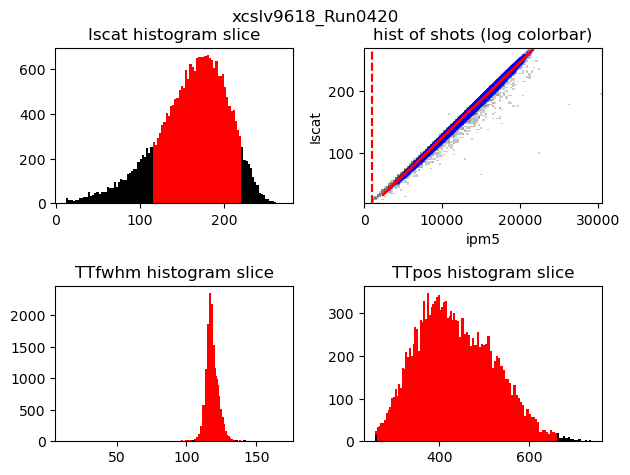

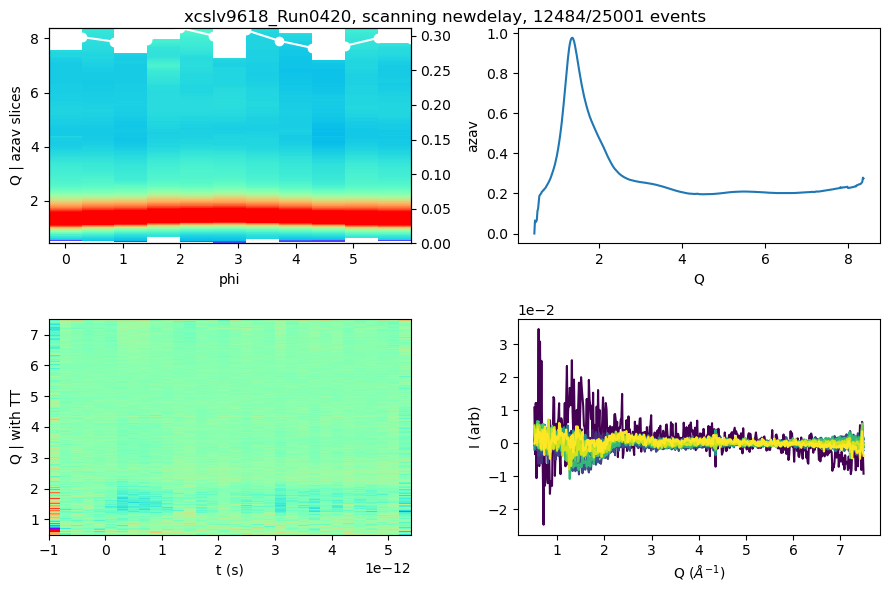

In [4]:
runs=[419,420]

ReduceData(smalldata_folder,exper,runs,outpath,paramDict,varDict)
    

# Stack Runs 

In [5]:
runpath=outpath+'npy/'
runs2=[419,420]

stackDict=StackProccessed(runpath,exper,runs2,method='bincount')

In [6]:
#load variables from stack

print(stackDict.keys())
diff=stackDict['aveData']
ts=stackDict['ts']
qs=stackDict['qs']
phis=stackDict['phis']


dict_keys(['aveData', 'errData', 'sumBC', 'ts', 'qs', 'phis', 'runs', 'method'])


In [7]:
#do anisotropy

S0,S0_err,S2,S2_err=S0S2(diff,phis,shift_n=1)

shift is 32 degrees
32
31

Text(0.5, 0.98, '$\\Delta$S2')

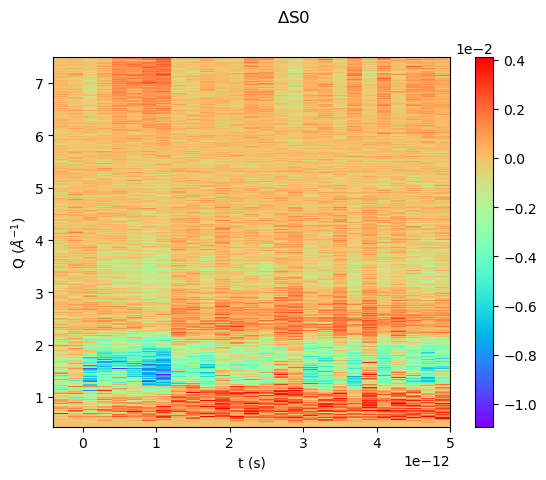

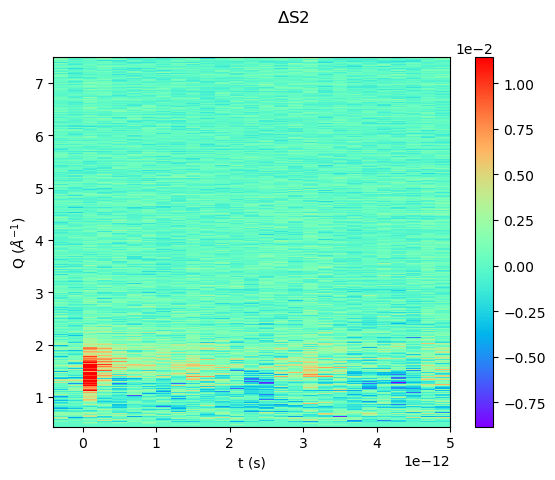

In [8]:
#plot

qrange=(0.3,7.5)
trange=(-0.5e-12,5e-12)

goodq=np.nonzero( (qrange[0]<qs) & (qs<qrange[1]) )
goodt=np.nonzero( (trange[0]<ts) & (ts<trange[1]) )

plot_2d(ts[goodt],qs[goodq],S0[goodt,:].squeeze()[:,goodq].squeeze())
# plt.clim(-2e-4,2e-4)
plt.suptitle('$\Delta$S0')
plot_2d(ts[goodt],qs[goodq],S2[goodt,:].squeeze()[:,goodq].squeeze())
# plt.clim(-2e-4,2e-4)
plt.suptitle('$\Delta$S2')